In [2]:
#importing the libraries and reading the data
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


song_id             0
track_id            0
artist_name         0
track_name          0
album_name          0
track_genre         0
popularity          0
energy              0
acousticness        0
valence             0
tempo               0
speechiness         0
instrumentalness    0
dtype: int64
User's unique genres: ['club' 'dance' 'emo' 'hip-hop' 'house' 'indie-pop' 'indie' 'latin' 'pop'
 'rock' 'sad']
Filtered dataset unique genres: ['club' 'dance' 'emo' 'hip-hop' 'house' 'indie-pop' 'indie' 'latin' 'pop'
 'rock' 'sad']


C:\Users\sriuj\AppData\Local\Temp\ipykernel_24124\2124656627.py:103: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(user_songs_2d[:, 0], user_songs_2d[:, 1], cmap='viridis')


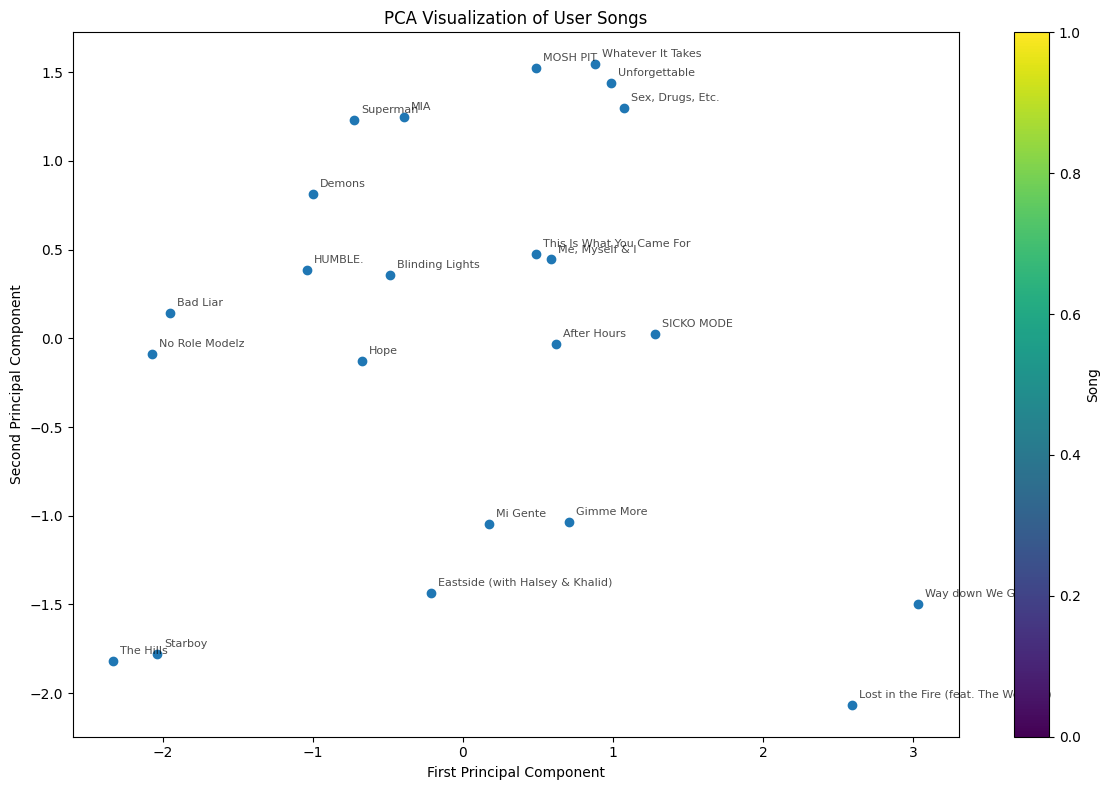

User Songs: 

Song ID: 67016
Track Name: MIA
Artist Name: Bad Bunny;Drake
Album Name: Today's Party Hits

Song ID: 91000
Track Name: Sex, Drugs, Etc.
Artist Name: Beach Weather
Album Name: Chit Chat

Song ID: 81004
Track Name: Starboy
Artist Name: The Weeknd;Daft Punk
Album Name: Starboy

Song ID: 17000
Track Name: Lost in the Fire (feat. The Weeknd)
Artist Name: Gesaffelstein;The Weeknd
Album Name: Hyperion

Song ID: 20414
Track Name: Eastside (with Halsey & Khalid)
Artist Name: benny blanco;Halsey;Khalid
Album Name: FRIENDS KEEP SECRETS

Song ID: 81000
Track Name: Blinding Lights
Artist Name: The Weeknd
Album Name: After Hours

Song ID: 81074
Track Name: The Hills
Artist Name: The Weeknd
Album Name: Drippy Drippy

Song ID: 81109
Track Name: After Hours
Artist Name: The Weeknd
Album Name: Halloween Party 2022

Song ID: 20652
Track Name: Gimme More
Artist Name: Britney Spears
Album Name: Blackout

Song ID: 91016
Track Name: Whatever It Takes
Artist Name: Imagine Dragons
Album Name: Evo

C:\Users\sriuj\AppData\Local\Temp\ipykernel_24124\2124656627.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['similarity'] = aggregated_similarities


In [4]:
# Step 1: Load the Dataset
df = pd.read_csv('spotify_Song_Dataset/dataset.csv')

# Step 2: Data Cleaning and Preprocessing

# Remove rows with null values
df = df.dropna()

# Drop irrelevant columns like duration and explicit tags
df = df.drop(['duration_ms', 'explicit', 'mode', 'liveness', 'loudness', 'time_signature', 'key'], axis=1)

# Rename the first column to 'song_id' if unnamed
df.rename(columns={'Unnamed: 0': 'song_id'}, inplace=True)

# Step 3: Feature Scaling

# Define the continuous audio features and popularity for scaling
features_to_scale = ['popularity', 'danceability', 'energy', 'acousticness', 'valence', 'tempo', 'speechiness', 'instrumentalness']

# Handle extreme outliers using z-scores (only for the continuous features)
from scipy import stats
z_scores = stats.zscore(df[features_to_scale])
outliers = (z_scores > 5) | (z_scores < -5)
df = df[(~outliers).all(axis=1)]  # Remove rows with extreme outliers

# Initialize the MinMaxScaler to scale features between 0 and 1
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
scaled_features = scaler.fit_transform(df[features_to_scale])

# Convert the scaled features back to a DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale)

# Step 4: Add the original identification and categorical columns back to the DataFrame
df_scaled['song_id'] = df['song_id']
df_scaled['track_id'] = df['track_id']
df_scaled['artist_name'] = df['artists'].fillna('')  # Fill NaN with empty string for artist names
df_scaled['track_name'] = df['track_name']
df_scaled['album_name'] = df['album_name'].fillna('')  # Fill NaN with empty string for album names
df_scaled['track_genre'] = df['track_genre'].fillna('')  # Fill NaN with empty string for genres

# Step 5: Remove any remaining rows with missing values
df_scaled = df_scaled.dropna()

# Reorder columns to have song info first
df_scaled = df_scaled[['song_id', 'track_id', 'artist_name', 'track_name', 'album_name', 'track_genre',
                       'popularity', 'energy', 'acousticness', 'valence', 'tempo', 'speechiness', 'instrumentalness']]

# Remove duplicate rows
df_scaled = df_scaled.drop_duplicates()

# Step 6: Save the final cleaned dataset
df_scaled.to_csv('spotify_Song_Dataset/final_dataset.csv', index=False)

# Step 7: Check for any remaining NaN values
print(df_scaled.isnull().sum())

# Step 8: Define Features and Recommendation Functionality

# Define the features for similarity calculation, excluding popularity and artist names
features = ['energy', 'acousticness', 'valence', 'tempo', 'speechiness', 'instrumentalness']

# Define the weighted importance for each feature (weights can be adjusted as needed)
feature_weights = {
    'energy': 1.0,
    'acousticness': 5.0,
    'valence': 5.0,
    'tempo': 5.0,
    'instrumentalness': 5.0,
    'speechiness': 5.0,
}

def filter_songs_by_genre(user_songs_df, df, genre_column='track_genre'):
    """
    Filter the dataset to include only songs with genres that exist in the user's playlist.
    :param user_songs_df: DataFrame of user songs.
    :param df: Full song DataFrame.
    :param genre_column: Column name containing genre information.
    :return: Filtered DataFrame based on genres in the user playlist.
    """
    # Extract unique genres from the user's songs
    user_genres = user_songs_df[genre_column].unique()
    
    # Filter the dataset to include only songs with the user's genres
    filtered_df = df[df[genre_column].isin(user_genres)]
    
    return filtered_df

def cluster_user_songs(user_songs_df, features):
    """
    Cluster user songs using PCA for visualization.
    """
    scaler = StandardScaler()
    user_songs_scaled = scaler.fit_transform(user_songs_df[features])
    
    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    user_songs_2d = pca.fit_transform(user_songs_scaled)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(user_songs_2d[:, 0], user_songs_2d[:, 1], cmap='viridis')
    plt.title('PCA Visualization of User Songs')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter, label='Song')
    
    # Annotate points with song names
    for i, (x, y) in enumerate(user_songs_2d):
        plt.annotate(user_songs_df['track_name'].iloc[i], (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return user_songs_df


def recommend_songs_filtered(user_songs, df, features, feature_weights, top_n=0, similarity_threshold=0.0):
    """
    Recommend songs based on cosine similarity, filtering songs by genres from the user's playlist.
    """
    df_copy = df.copy()

    # Apply feature weights
    for feature in features:
        df_copy[feature] = df_copy[feature] * feature_weights.get(feature, 1.0)
    
    # Get user songs dataframe
    user_songs_df = df_copy[df_copy['song_id'].isin(user_songs)]
    
    # Filter the full dataset to include only songs with genres in the user's playlist
    filtered_df = filter_songs_by_genre(user_songs_df, df_copy)
    
    # Debugging: Print the unique genres in the user songs and filtered dataset
    print(f"User's unique genres: {user_songs_df['track_genre'].unique()}")
    print(f"Filtered dataset unique genres: {filtered_df['track_genre'].unique()}")
    
    # Cluster user songs for visualization (optional)
    cluster_user_songs(user_songs_df, features)
    
    # Compute cosine similarity between all songs in the filtered dataset and the user's songs
    similarity_matrix = cosine_similarity(filtered_df[features], user_songs_df[features])
    
    # Aggregate the similarity scores across all user songs
    aggregated_similarities = similarity_matrix.mean(axis=1)
    
    # Add the similarity scores to the dataframe
    filtered_df['similarity'] = aggregated_similarities
    
    # Exclude the user's input songs from the recommendations
    recommendations = filtered_df[~filtered_df['song_id'].isin(user_songs)]
    
    # If a similarity threshold is provided, filter and then sort by similarity and popularity
    if similarity_threshold > 0.0:
        recommendations = recommendations[recommendations['similarity'] >= similarity_threshold]
    
    # Sort by similarity and popularity
    recommendations = recommendations.sort_values(by=['similarity', 'popularity'], ascending=[False, False])
    
    # If top_n is provided, get the top N results
    if top_n > 0:
        recommendations = recommendations.head(top_n)
    
    return recommendations


# Example usage:
user_songs = [67016, 91000, 81004, 17000, 20414, 81000, 81074, 81109, 20652, 91016, 91017, 91018, 51150, 51503, 56064, 33012, 57162, 53050, 67351, 51450, 94632, 51500, 53055]
recommended_songs = recommend_songs_filtered(user_songs, df_scaled, features, feature_weights, top_n=200)

# Printing the user songs
print("User Songs: \n")
for song_id in user_songs:
    song = df_scaled[df_scaled['song_id'] == song_id]
    print(f"Song ID: {song_id}")
    print(f"Track Name: {song['track_name'].values[0]}")
    print(f"Artist Name: {song['artist_name'].values[0]}")
    print(f"Album Name: {song['album_name'].values[0]}\n")

# Print the recommended songs
print("Recommended Songs: \n")
for index, row in recommended_songs.iterrows():
    print(f"Song ID: {row['song_id']}, Similarity: {row['similarity']:0.4f}")
    print(f"Track Name: {row['track_name']}")
    print(f"Artist Name: {row['artist_name']}")
    print(f"Album Name: {row['album_name']}\n")


User's unique genres: ['club' 'dance' 'emo' 'hip-hop' 'house' 'indie-pop' 'indie' 'latin' 'pop'
 'rock' 'sad']
Filtered dataset unique genres: ['club' 'dance' 'emo' 'hip-hop' 'house' 'indie-pop' 'indie' 'latin' 'pop'
 'rock' 'sad']


C:\Users\sriuj\AppData\Local\Temp\ipykernel_24124\2124656627.py:103: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(user_songs_2d[:, 0], user_songs_2d[:, 1], cmap='viridis')


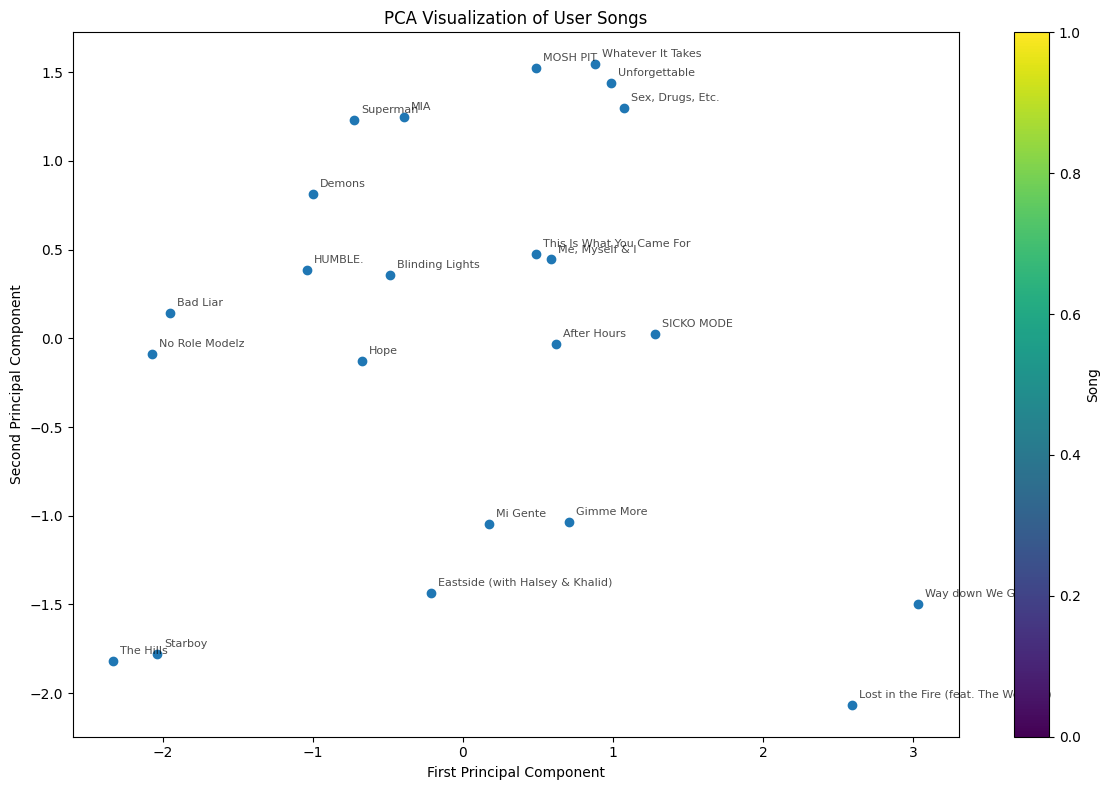

C:\Users\sriuj\AppData\Local\Temp\ipykernel_24124\2124656627.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['similarity'] = aggregated_similarities


Recommendation: Song ID 81276.0, Song Name: The Christmas Song (Chestnuts Roasting On An Open Fire) by Justin Bieber;Usher
Recommendation: Song ID 67923.0, Song Name: One, Two, Three, GO! by Belanova
Recommendation: Song ID 57711.0, Song Name: All For Us by Labrinth;Zendaya
Recommendation: Song ID 33850.0, Song Name: Bad Blood (feat. Tory Lanez) by kizaru;Tory Lanez
Recommendation: Song ID 94945.0, Song Name: Gorilla Grip by Sinoda
Recommendation: Song ID 56082.0, Song Name: Hate Me by Ellie Goulding;Juice WRLD
Recommendation: Song ID 20144.0, Song Name: Time After Time - Live At Abbey Road Studios by Sam Smith
Recommendation: Song ID 53075.0, Song Name: Belly Dancer by Imanbek;BYOR
Recommendation: Song ID 81003.0, Song Name: Under The Influence by Chris Brown
Recommendation: Song ID 20591.0, Song Name: I Gotta Feeling by Black Eyed Peas
Episode 1 finished.
Recommendation: Song ID 33236.0, Song Name: Famous Last Words by My Chemical Romance
Recommendation: Song ID 33236.0, Song Name: F

In [6]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# DQN Model Definition
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize components for the DQN
state_size = 9  # 9 features (mood + song features)

# Load the dataset
df_scaled = pd.read_csv('spotify_Song_Dataset/final_dataset.csv')

# Simulate the song environment with a constant mood until updated
user_mood = [1, 0, 0]  # Initially positive mood (this can be updated by the user)

# Function to generate the initial state (mood + placeholder song features)
def get_initial_state():
    avg_song_features = [0.5, 0.5, 0.5, 120, 0.5]  # Placeholder average song features
    return user_mood + avg_song_features

# Function to get feedback from the user
def get_user_feedback(action, df, current_mood):
    """
    Get feedback from the user based on the song recommendation.
    The song ID is passed and the mood remains unchanged unless updated.
    """
    song_id = df.iloc[action]['song_id']
    print(f"Recommendation: Song ID {song_id}, Song Name: {df.iloc[action]['track_name']} by {df.iloc[action]['artist_name']}")
    
    # Ask for user feedback (like or dislike) or an option to exit
    feedback = input("Do you like this recommendation? (y/n/exit): ").lower().strip()
    
    if feedback == 'y':
        reward = 1  # Like
    elif feedback == 'n':
        reward = -1  # Dislike
    elif feedback == 'exit':
        return 'exit', None  # Exit condition to break out of the loop
    else:
        reward = 0  # Neutral feedback (if the user presses anything else)
    
    # Mood remains unchanged unless explicitly updated
    next_state = current_mood + list(df.iloc[action][['energy', 'valence', 'acousticness', 'tempo', 'speechiness']].values)
    
    return next_state, reward

# Action selection based on exploration-exploitation tradeoff
def select_action(state, eps_threshold, action_size):
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(torch.tensor(state).float()).argmax().item()
    else:
        return random.randrange(action_size)

# DQN optimization
def optimize_model():
    if len(memory) < batch_size:
        return
    
    transitions = random.sample(memory, batch_size)
    batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)

    batch_state = torch.tensor(batch_state).float()
    batch_action = torch.tensor(batch_action).long()
    batch_reward = torch.tensor(batch_reward).float()
    batch_next_state = torch.tensor(batch_next_state).float()

    q_values = policy_net(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
    next_q_values = target_net(batch_next_state).max(1)[0]
    expected_q_values = batch_reward + (gamma * next_q_values)

    loss = nn.functional.mse_loss(q_values, expected_q_values)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Update the target network periodically
def update_target_network():
    target_net.load_state_dict(policy_net.state_dict())

# Pre-filtered recommendations based on cosine similarity
recommended_songs_df = recommend_songs_filtered(user_songs, df_scaled, features, feature_weights, top_n=200)
action_size = len(recommended_songs_df)  # Action size now depends on filtered recommendations

# Initialize the DQN model with dynamic action size
policy_net = DQN(state_size, action_size)
target_net = DQN(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters())
memory = deque(maxlen=10000)

# DQN Hyperparameters
eps_start = 1.0  # Initial exploration rate
eps_end = 0.1  # Minimum exploration rate
eps_decay = 0.995  # Decay rate for exploration-exploitation balance
batch_size = 32  # Mini-batch size
gamma = 0.99  # Discount factor
target_update = 10  # Frequency of updating the target network

eps_threshold = eps_start  # Initialize epsilon threshold

# Training loop for DQN
num_episodes = 10

for episode in range(num_episodes):
    state = get_initial_state()  # Initialize state with user mood and song features
    
    for t in range(10):  # Generate 10 recommendations per episode
        action = select_action(state, eps_threshold, action_size)  # Select a song to recommend
        
        # Get feedback from the user using the pre-filtered recommendations
        next_state, reward = get_user_feedback(action, recommended_songs_df, user_mood)
        
        # Exit condition based on user feedback
        if next_state == 'exit':
            print("\nExiting the training early...")
            break
        
        # Store the experience in memory
        memory.append((state, action, reward, next_state))
        
        # Optimize the model
        optimize_model()
        
        state = next_state  # Move to the next state (same mood, different song features)
    
    print(f"Episode {episode+1} finished.")
    
    # Decay epsilon for exploration-exploitation balance
    eps_threshold *= eps_decay
    eps_threshold = max(eps_end, eps_threshold)
    
    # Update the target network every few episodes
    if episode % target_update == 0:
        update_target_network()

# After training, you can generate new recommendations from the pre-filtered list:
print("\nTraining finished. Generating recommendations from pre-filtered list...")
recommended_song_ids = recommend_songs_from_filtered(recommended_songs_df, num_recommendations=10)
print(f"Recommended Song IDs: {recommended_song_ids}")


# VADER SENTIMENT ANALYSIS

In [12]:
def analyze_user_emotion(user_text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(user_text)
    
    # Determine the emotion based on the sentiment scores
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'